In [14]:
import pandas as pd
from app import app, db, Reservation, DeviceStatus, User
from datetime import datetime, timedelta
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import re
import numpy as np


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [15]:
df1 = pd.read_csv('data\Sign up form for Esports room (Antwoorden) - Formulierreacties 1.csv')

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\samue\AppData\Local\Temp\ipykernel_27204\2635127739.py:1: SyntaxWarning: invalid escape sequence '\S'
  df1 = pd.read_csv('data\Sign up form for Esports room (Antwoorden) - Formulierreacties 1.csv')


In [16]:
df1 = df1.drop(['Time of visit', 'Date of visit ', 'Free space for comments', 'Which game are you going to play?', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12','Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'], axis=1)

In [17]:
# Rename columns to match SQLAlchemy model
df1.rename(columns={
    'Full name': 'name',
    'Which university are you from? (If not from a uni, please let us know from where at the "other" section)': 'school',
    'E-mailadres': 'email',
    'What PC/Console will you use?': 'device',
    'Tijdstempel': 'date'
}, inplace=True)

In [18]:
#df1.fillna('N/A')

In [19]:
df1

,date,name,Student number,device,school,email
0,19-9-2022 15:41:23,Jian Jin He,193099,NaN,NaN,NaN
1,19-9-2022 15:41:27,Thomas Pichardo,223834,NaN,NaN,NaN
2,19-9-2022 15:41:31,Samuel Antonio Vieira Vasconcelos,211941,NaN,NaN,NaN
3,19-9-2022 15:41:55,Juan José Gutierrez,215517,NaN,NaN,NaN
4,19-9-2022 15:42:07,Fedor Chursin,220905,NaN,NaN,NaN
...,...,...,...,...,...,...
2407,7-10-2024 16:19:02,Jack Woodley,243752,06,Buas,243752@buas.nl
2408,10-10-2024 10:36:09,Nikita Bezumovsky,+380685424290,09,Karazin uni Ukraine,nikita.bezumovsky@gmail.com
2409,10-10-2024 12:09:03,Stanisław Płoski,232416,02,Buas,stachuploski@gmail.com
2410,10-10-2024 12:27:55,Achilles Lordos,230746,03,Buas,230746@buas.nl


# Pre Process Student Number Column

In [20]:
def process_student_number(number):
    if pd.isna(number):
        return 'N/A', 'N/A'
    
    # Remove any non-digit characters for processing
    cleaned_number = re.sub(r'\D', '', str(number))
    
    # Check if the cleaned number is exactly 6 digits
    if len(cleaned_number) == 6:
        return cleaned_number, 'N/A'
    else:
        # Check if the original number is a phone number
        if re.match(r'^\+|\d{10,}$', str(number)):
            return 'N/A', number
        else:
            return 'N/A', 'N/A'

In [21]:
# Apply the function to the dataframe
df1[['Student number', 'phone_number']] = df1['Student number'].apply(process_student_number).apply(pd.Series)

In [22]:
df1

,date,name,Student number,device,school,email,phone_number
0,19-9-2022 15:41:23,Jian Jin He,193099,NaN,NaN,NaN,N/A
1,19-9-2022 15:41:27,Thomas Pichardo,223834,NaN,NaN,NaN,N/A
2,19-9-2022 15:41:31,Samuel Antonio Vieira Vasconcelos,211941,NaN,NaN,NaN,N/A
3,19-9-2022 15:41:55,Juan José Gutierrez,215517,NaN,NaN,NaN,N/A
4,19-9-2022 15:42:07,Fedor Chursin,220905,NaN,NaN,NaN,N/A
...,...,...,...,...,...,...,...
2407,7-10-2024 16:19:02,Jack Woodley,243752,06,Buas,243752@buas.nl,N/A
2408,10-10-2024 10:36:09,Nikita Bezumovsky,N/A,09,Karazin uni Ukraine,nikita.bezumovsky@gmail.com,+380685424290
2409,10-10-2024 12:09:03,Stanisław Płoski,232416,02,Buas,stachuploski@gmail.com,N/A
2410,10-10-2024 12:27:55,Achilles Lordos,230746,03,Buas,230746@buas.nl,N/A


In [23]:
# Create SQLAlchemy engine
engine = create_engine('sqlite:///instance/reservations.db')
Session = sessionmaker(bind=engine)
session = Session()

In [24]:
def map_df_to_model(df):
    reservations = []
    for index, row in df.iterrows():
        # Initialize date variable
        date = None
        
        if isinstance(row['date'], str):
            # Try parsing with different formats
            try:
                # Try with seconds
                date = datetime.strptime(row['date'], '%d-%m-%Y %H:%M:%S')
            except ValueError:
                try:
                    # Try without seconds
                    date = datetime.strptime(row['date'], '%d-%m-%Y %H:%M')
                except ValueError:
                    # Handle if neither format works
                    print(f"Failed to parse date: {row['date']}")
                    continue  # Skip this row if parsing fails
        else:
            # Convert Timestamp to datetime if it's not a string
            date = row['date'].to_pydatetime()

        # Create a Reservation instance
        reservation = Reservation(
            name=row['name'],
            school=row['school'] if pd.notna(row['school']) else 'Unknown',
            email=row['email'] if pd.notna(row['email']) else 'Unknown',
            device=row['device'] if pd.notna(row['device']) else 'Unknown',
            student_number=row['Student number'] if pd.notna(row['Student number']) else 'Unknown',
            pin_hash='N/A',
            date=date
        )
        reservations.append(reservation)
    
    return reservations


In [25]:
# Insert DataFrame data into the database
reservations = map_df_to_model(df1)

try:
    session.add_all(reservations)
    session.commit()
    print("Data inserted successfully.")
except Exception as e:
    session.rollback()
    print(f"An error occurred: {e}")
finally:
    session.close()

Data inserted successfully.


In [26]:
# Check current database entries
with app.app_context():
    # Query all reservations
    reservations = Reservation.query.all()
    print("Reservations:", reservations)

    # Query all device statuses
    device_statuses = DeviceStatus.query.all()
    print("Device Statuses:", device_statuses)

    # Query all users
    users = User.query.all()
    print("Users:", users)

    # Query reservations in the last 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=1)
    reservations_last_24_hours = Reservation.query.filter(
        Reservation.date.between(start_date, end_date)
    ).all()
    print("Reservations in Last 24 Hours:", reservations_last_24_hours)

Reservations: [<Reservation 1 | Student Number: 193099 | Name: Jian Jin He | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:23>, <Reservation 2 | Student Number: 223834 | Name: Thomas Pichardo | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:27>, <Reservation 3 | Student Number: 211941 | Name: Samuel Antonio Vieira Vasconcelos | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:31>, <Reservation 4 | Student Number: 215517 | Name: Juan José Gutierrez | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:41:55>, <Reservation 5 | Student Number: 220905 | Name: Fedor Chursin | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 15:42:07>, <Reservation 6 | Student Number: 191019 | Name: Thijs Massink | School: Unknown | Email: Unknown | Device: Unknown | Date: 2022-09-19 16:10:50>, <Reservation 7 | Student Number: 215434 | Name: Danyel Fijten | School: Unknown | Email: 

# The Hive - Visitors Count

In [27]:
df1.columns

Index(['date', 'name', 'Student number', 'device', 'school', 'email',
       'phone_number'],
      dtype='object')

In [28]:
df1['date'] = pd.to_datetime(df1['date'], format="%d-%m-%Y %H:%M:%S", errors='coerce', dayfirst=True)


In [29]:
# Step 2: Extract day of the week and year
df1['day_of_week'] = df1['date'].dt.day_name()
df1['year'] = df1['date'].dt.year

# Step 3: Group by year and day of the week, and count entries
average_entries = df1.groupby(['year', 'day_of_week']).size().reset_index(name='entries')


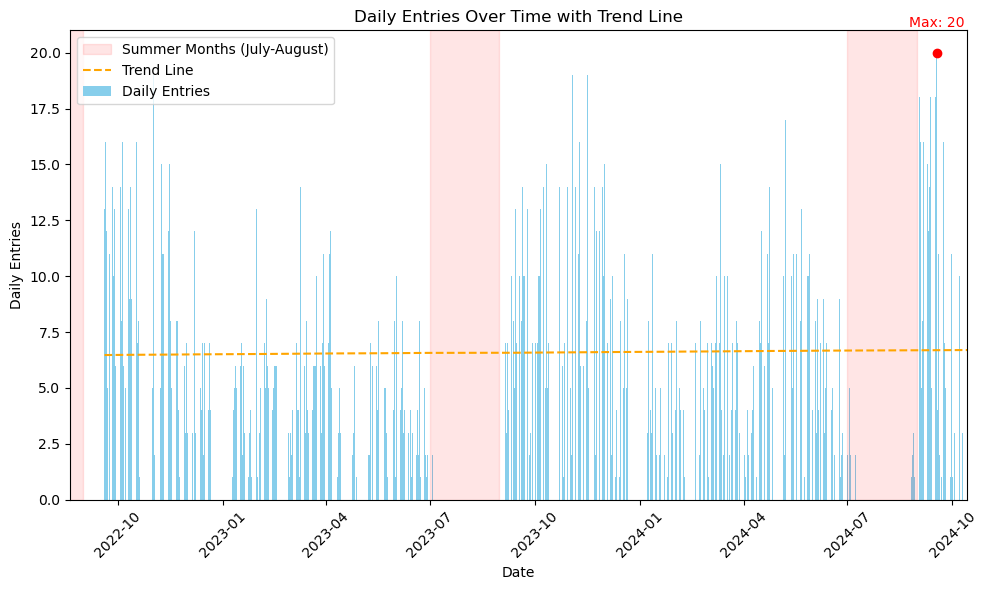

In [30]:
# Ensure 'date' column is in datetime format
df1['date'] = pd.to_datetime(df1['date'])

# Extract just the date part from the datetime
df1['date_only'] = df1['date'].dt.date

# Group by the 'date_only' column and count the entries for each day
daily_entries = df1.groupby('date_only').size()

# Convert 'daily_entries.index' to a datetime index to enable year extraction
daily_entries.index = pd.to_datetime(daily_entries.index)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(daily_entries.index, daily_entries.values, color='skyblue', label='Daily Entries')

# Adding a trend line
z = np.polyfit(range(len(daily_entries)), daily_entries.values, 1)  # Linear fit (degree=1)
p = np.poly1d(z)
trend_line, = plt.plot(daily_entries.index, p(range(len(daily_entries))), color='orange', linestyle='--', label='Trend Line')

# Adding red zones for the summer months (July, August) of each year
for year in daily_entries.index.year.unique():
    start_date = pd.Timestamp(f"{year}-07-01")
    end_date = pd.Timestamp(f"{year}-08-31")
    plt.axvspan(start_date, end_date, color='red', alpha=0.1)

# Custom legend entries for red and gray zones
summer_patch = mpatches.Patch(color='red', alpha=0.1, label='Summer Months (July-August)')

# Find the maximum value and its corresponding date
max_value = daily_entries.max()
max_date = daily_entries.idxmax()

# Add a marker for the maximum value on the bar chart
plt.scatter(max_date, max_value, color='red', zorder=5)
plt.text(max_date, max_value + 1, f'Max: {max_value}', color='red', ha='center', va='bottom')

# Formatting the chart
plt.xlim([daily_entries.index.min() - pd.Timedelta(days=30), daily_entries.index.max()])
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.title('Daily Entries Over Time with Trend Line')

# Adding all legend entries
plt.legend(handles=[summer_patch, trend_line, bar_plot], loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the chart
plt.show()

# Discord Members Count

In [31]:
members = pd.read_csv('data/members.csv')

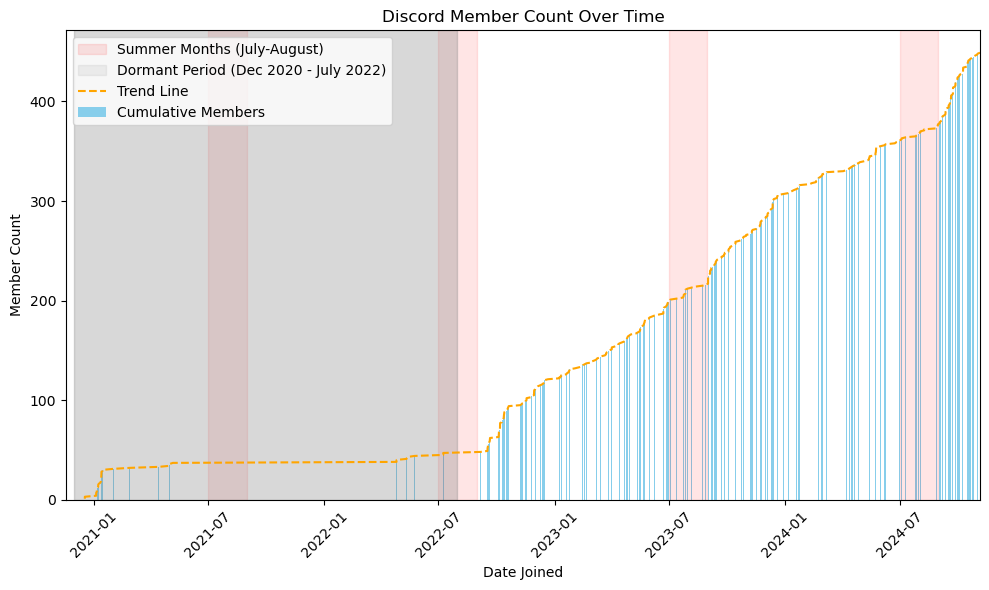

In [33]:
# Ensure 'joined' column is in datetime format
members['joined'] = pd.to_datetime(members['joined'])

# Group by 'joined' date and count the number of members who joined on each date
member_counts = members.groupby('joined').size().cumsum()  # Cumulative count over time

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(member_counts.index, member_counts.values, color='skyblue', label='Cumulative Members')

# Adding a trend line
z = np.polyfit(range(len(member_counts)), member_counts.values, 1)  # Linear fit (degree=1)
p = np.poly1d(z)
trend_line, = plt.plot(member_counts.index, p(range(len(member_counts))), color='orange', linestyle='--', label='Trend Line')

# Add red zones for the summer months (July, August) of each year in the data
for year in member_counts.index.year.unique():
    start_date = pd.Timestamp(f"{year}-07-01")
    end_date = pd.Timestamp(f"{year}-08-31")
    plt.axvspan(start_date, end_date, color='red', alpha=0.1)

# Add gray zone for the dormant period
start_date = pd.Timestamp("2020-12-01")
end_date = pd.Timestamp("2022-07-31")
plt.axvspan(start_date, end_date, color='gray', alpha=0.3)

# Custom legend entries for red and gray zones
summer_patch = mpatches.Patch(color='red', alpha=0.1, label='Summer Months (July-August)')
dormant_patch = mpatches.Patch(color='gray', alpha=0.1, label='Dormant Period (Dec 2020 - July 2022)')

# Formatting the chart
plt.xlim([member_counts.index.min() - pd.Timedelta(days=30), member_counts.index.max()])
plt.xlabel('Date Joined')
plt.ylabel('Member Count')
plt.title('Discord Member Count Over Time')

# Adding all legend entries
plt.legend(handles=[summer_patch, dormant_patch, trend_line, bar_plot], loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the chart
plt.show()